# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline 
# !pip install mpld3
# import mpld3
# mpld3.enable_notebook()

from scipy.integrate import odeint
# !pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

# import warnings
# warnings.filterwarnings('ignore')

# Curve Fitting Example

We want to fit the following curve:

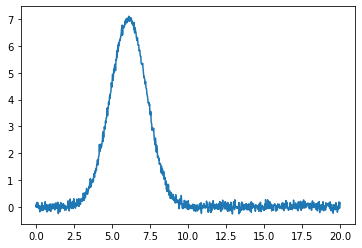

In [2]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (gaussian(x, 21, 6.1, 1.2) + np.random.normal(scale=0.1, size=x.size))  # normal distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [3]:
def f(x, a, b, c):
    return gaussian(x, a, b, c) 

In [4]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=10.0, vary=True)
mod.set_param_hint("b", value=10.0, vary=True)
mod.set_param_hint("c", value=10.0, vary=True)

params = mod.make_params()

In [5]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 21.032607062044605, 'b': 6.100343154231887, 'c': 1.2009255098840932}

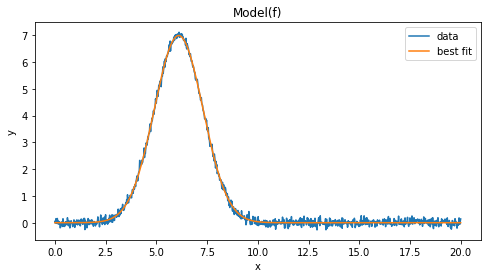

In [6]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [7]:
result

# Supplemental and Coronavirus Data

In [8]:
covid_url = "https://proxy.hxlstandard.org/hxlproxy/data/download/time_series_covid19_deaths_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv"

In [9]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
beds = pd.read_csv("data/beds.csv", header=0)
agegroups = pd.read_csv("data/agegroups.csv")
probabilities = pd.read_csv("data/probabilities.csv")
covid_data = pd.read_csv(covid_url, parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

/tmp/ipykernel_20882/2229032058.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_data = pd.read_csv(covid_url, parse_dates=["Date"], skiprows=[1])


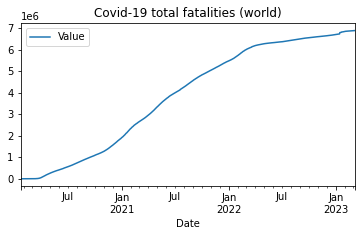

In [10]:
covid_data.groupby("Date").sum()[["Value"]].plot(figsize=(6, 3), title="Covid-19 total fatalities (world)");

## Plotting

In [11]:
# plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

# Model

In [12]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [13]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = beta(t)/gamma

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

percentage going to ICU: 5.0; percentage dying in ICU: 60.0


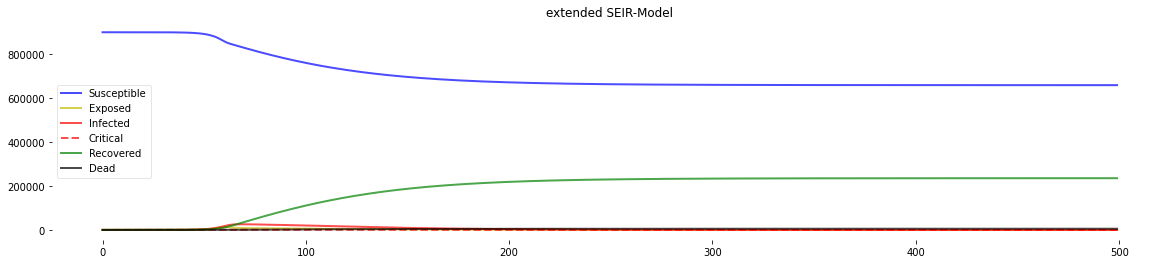

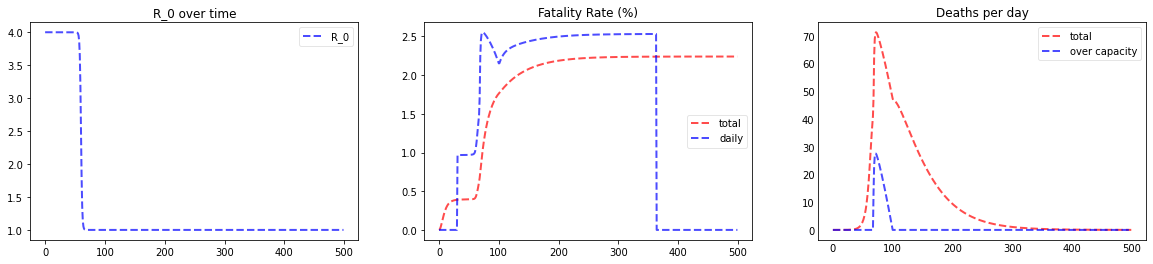

In [14]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

# Fitting

In [15]:
# parameters
data = covid_data[covid_data["Location"] == "Italy"]["Value"].values[::-1]
agegroups = agegroup_lookup["Italy"]
beds_per_100k = beds_lookup["Italy"]
outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [16]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [17]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6]

In [18]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [19]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

/tmp/ipykernel_20882/2973988813.py:5: RuntimeWarning: overflow encountered in exp
  return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end


/tmp/ipykernel_20882/2973988813.py:5: RuntimeWarning: overflow encountered in exp
  return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end


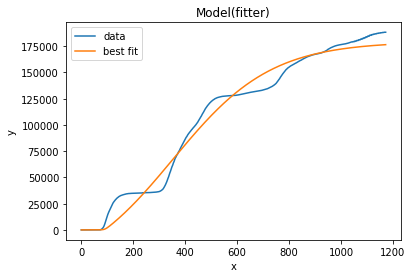

In [20]:
result.plot_fit(datafmt="-");

In [21]:
result.best_values

{'R_0_start': 2.984752991058375,
 'k': 2.235447936606924,
 'x0': 88.5567366695525,
 'R_0_end': 1.0220960726462798,
 'prob_I_to_C': 0.07130025250016654,
 'prob_C_to_D': 0.5813501328216514,
 's': 0.003}

/tmp/ipykernel_20882/2973988813.py:5: RuntimeWarning: overflow encountered in exp
  return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end


Prediction for Italy
percentage going to ICU: 7.130025250016654; percentage dying in ICU: 58.13501328216514


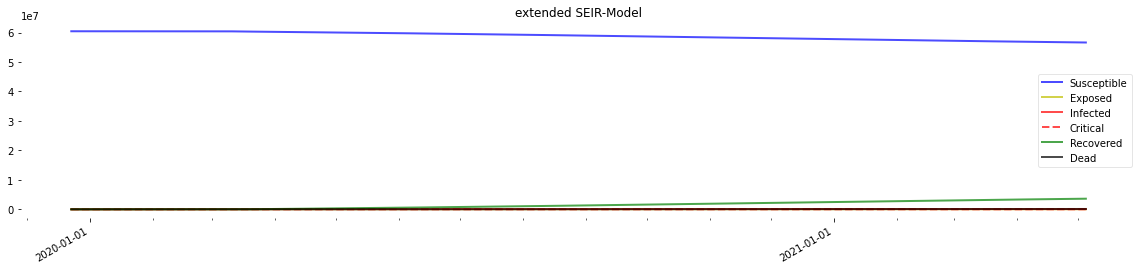

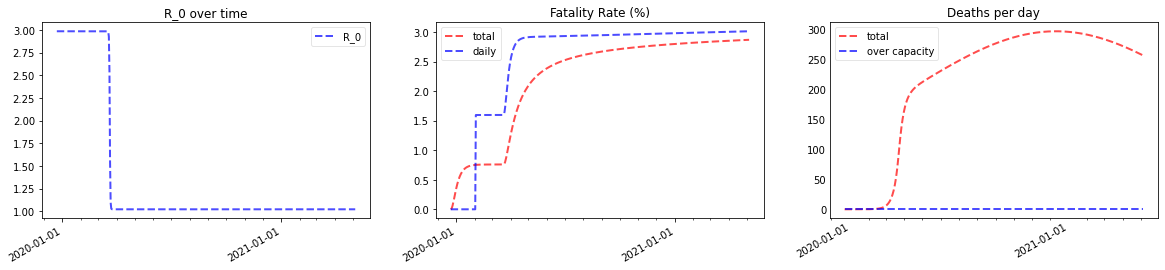

In [22]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Italy")
plotter(*Model(full_days, agegroup_lookup["Italy"], beds_lookup["Italy"], **result.best_values), x_ticks=x_ticks);